<function matplotlib.pyplot.show(close=None, block=None)>

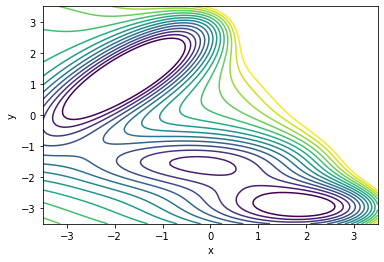

In [1]:
## We start by importing modules, defining parameters for cFFS
## and langevin dynamics, and plotting the potential.

## Can use PES-1 or PES-3 by commenting/uncommenting
## lines in langevin_dynamics.py. 

# Standard imports here
import sys
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm
%matplotlib inline

# Here we import functions to perform Langevin dynamics
import langevin_dynamics as ld

# Here we import helper functions for cFFS --> these make
# this code shorter but feel free to look at the functions
# to understand them.
import cffs_util as cffs

#cFFS settings
interface_trajs = 5000   # number of trajectories to launch from each interface
cross_threshold = 500    # number of configurations desired at each interface
basineqlen = 50000       # basin equilibration time (in steps)
basinlen = 500000        # basin simulation time
n_interfaces = 10        # Max number of interfaces to run
basin_threshold = 2      # Probability density threshold to define basin A
# This value changes with PES. PES-1 = 2 a good choice
# and PES-3 = 0.5 good choice. In practice this would be adjusted to
# find a reasonable value. 


# Langevin dynamics settings
beta = 2.5      # 1/kT
gamma = 5       # friction coefficient
dt = 0.01       # time step size
init_coords = [-1, -1]   # initial coordinates
init_p = [0, 0]          # initial momenta

# Plot potential energy surface contours
pes_type = 5
N = 100
x_vec = np.linspace(-3.5, 3.5, N)
y_vec = np.linspace(-3.5, 3.5, N)
contours = [-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]
energy = np.zeros((N, N))
for i in range(len(x_vec)):
    for j in range(len(y_vec)):
        energy[j][i] = ld.potential(pes_type,x_vec[i],y_vec[j])
plt.contour(x_vec,y_vec,energy,contours)
plt.xlabel('x')
plt.ylabel('y')
plt.show

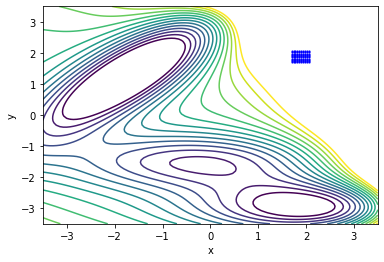

In [2]:
## Now we discretize the system with the Grid object
## create a definition for basin B, and plot basin B
## on the potential.

# Define grid object to discretize the system
grid_size = [0.04,0.04]
grid_min = [-5.0,-5.0]
grid_max = [5.0,5.0]
grid = cffs.Grid(grid_size,grid_min,grid_max)

# Define state B (crudely as a square)
# You may wish to edit the definition of B slightly for PES-3
B_min = [1.7,1.7]
B_max = [2.1,2.1]
B_bin_min = (int((B_min[0]-grid.min_cv1)/grid.size_cv1),
             int((B_min[1]-grid.min_cv2)/grid.size_cv2))
B_bin_max = (int((B_max[0]-grid.min_cv1)/grid.size_cv1),
             int((B_max[1]-grid.min_cv2)/grid.size_cv2))

basin_B_set = set()
for bin_cv1 in range(B_bin_min[0],B_bin_max[0]):
    for bin_cv2 in range(B_bin_min[1],B_bin_max[1]):
        basin_B_set.add((bin_cv1,bin_cv2))

# Show where we have defined basin B
x_range = [-3.5,3.5]
y_range = [-3.5,3.5]
point_size = 1
cffs.plot_set(x_range,y_range,contours,basin_B_set,grid,point_size,pes_type)

In [3]:
## Now we can run a basin simulation...this should look familiar...
## However, we cannot identify first crossings on-the-fly because 
## basin_A and lambda_0 are not yet defined! 


# declare array to store basin trajectory
basintraj = np.zeros((basinlen + 1, 6),dtype=float)
# calculate initial forces
fx,fy = ld.force(init_coords[0],init_coords[1],init_p[0],init_p[1],dt,beta,gamma,pes_type)
# combine positions, momenta, and forces to make an initial phase point
init_phasepoint = init_coords + init_p + [fx,fy]
basintrajeq = ld.vv_step(init_phasepoint,dt,beta,gamma,pes_type)

# Equilibrate in basin
for i in range(1,basineqlen + 1):
    new_basintrajeq = ld.vv_step(basintrajeq,dt,beta,gamma,pes_type)
    basintrajeq = new_basintrajeq
    bin_cv1 = int((basintrajeq[0]-grid.min_cv1)/grid.size_cv1)
    bin_cv2 = int((basintrajeq[1]-grid.min_cv2)/grid.size_cv2)
    loc = (bin_cv1,bin_cv2)
    # check if trajectory reaches basin B
    if loc in basin_B_set:
        sys.exit("Basin trajectory reached B! Exiting...")

basintraj[0] = basintrajeq
counts = {}
total_count = 0

# Run basin A simulation
# We can't id first crossings yet because we haven't defined
# basin A or the first interface, lambda_0
for j in range(1,basinlen + 1):
    basintraj[j] = ld.vv_step(basintraj[j-1],dt,beta,gamma,pes_type)
    bin_cv1 = int((basintraj[j][0]-grid.min_cv1)/grid.size_cv1)
    bin_cv2 = int((basintraj[j][1]-grid.min_cv2)/grid.size_cv2)
    loc = (bin_cv1,bin_cv2)
    # Track freqeuncy of loc
    if loc in counts:
        counts[loc] += 1
    else:
        counts[loc] = 1
    total_count += 1
    # Check if trajectory reaches basin B
    if loc in basin_B_set:
        sys.exit("Basin trajectory reached B! Exiting...")

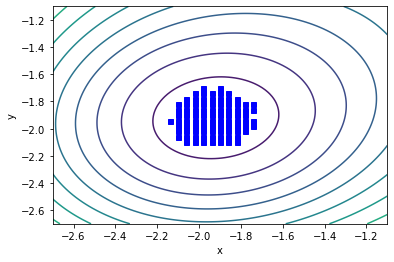

In [4]:
## Now we are going to ID basin A based upon sampling in basin simulation
## To ensure we have a well-defined basin there will be a few steps here...

# 1. Normalize counts to probability distribution
for site in counts:
    counts[site] /= (total_count*grid.size_cv1*grid.size_cv2)

# 2. Find sites that meet the threshold
meetthres = set()
for site in counts:
    if counts[site] > basin_threshold:
        meetthres.add(site)
# Plot sites that meet the threshold
x_range = [-2.7,-1.1]
y_range = [-2.7,-1.1]
point_size = 5
cffs.plot_set(x_range,y_range,contours,meetthres,grid,point_size,pes_type)

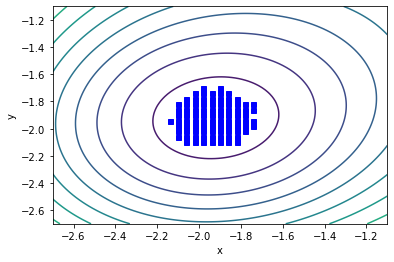

In [5]:
# 2. Find the largest set of touching sites that
#    meet the threshold
cls = cffs.idsetcls(meetthres,grid)
meetthres = max(cls, key=len)
# Plot
cffs.plot_set(x_range,y_range,contours,meetthres,grid,point_size,pes_type)

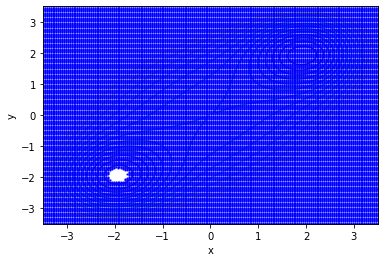

In [6]:
# 3. Find the largest set of touching sites that
#    are NOT part of the largest touching set of 
#    sites that meet the threshold
cls = cffs.idnosetcls(meetthres,grid)
noset = max(cls, key=len)

# Plot noset. The 'hole' is going to become the set
# describing the basin_A following the next step
x_range = [-3.5,3.5]
y_range = [-3.5,3.5]
point_size = 1
cffs.plot_set(x_range,y_range,contours,noset,grid,point_size,pes_type)

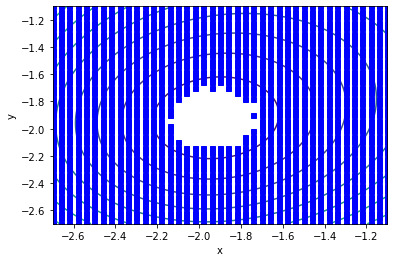

In [7]:
# Plot 'zoomed in' around basin_A
x_range = [-2.7,-1.1]
y_range = [-2.7,-1.1]
point_size = 5
cffs.plot_set(x_range,y_range,contours,noset,grid,point_size,pes_type)

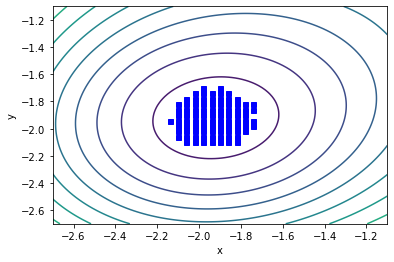

In [8]:
# OK, finally identify set for basin
## This is our final definition of the set defining basin A
basin_A_set = set()
for bin_cv1 in range(grid.nbins_cv1):
    for bin_cv2 in range(grid.nbins_cv2):
        if (bin_cv1,bin_cv2) not in noset:
            basin_A_set.add((bin_cv1,bin_cv2))
# Plot basin A
cffs.plot_set(x_range,y_range,contours,basin_A_set,grid,point_size,pes_type)

In [9]:
# Next we id the set defining the first interface
# The loc_edges function identifies an edge as any
# site that has < 4 neighbors in the same set.

# 1. Extend old set (i.e. starting from our basin A set)
#    This function adds a single 'layer' of sites
#    We do this first to ensure that interfaces do not overlap
newset = cffs.extend_set_everywhere(basin_A_set,basin_B_set,grid)

# 2. Use the same trick to ensure the set has no 'holes'
cls = cffs.idnosetcls(newset,grid) 
noset = max(cls, key=len)
lambda_0_set = set()
for bin_cv1 in range(grid.nbins_cv1):
    for bin_cv2 in range(grid.nbins_cv2):
        if (bin_cv1,bin_cv2) not in noset:
            lambda_0_set.add((bin_cv1,bin_cv2))

# 3. Find edges of set. Edges are any sites 
#    with < 4 neighbors in the same set
edges = cffs.loc_edges(lambda_0_set)
# 4. Calculate number of first crossings
#    exiting through each edge site.
first_crosses,n_cross,basin_count,avg_edgecount = cffs.calc_exit_basin(basintraj,grid,basin_A_set,lambda_0_set,edges)

In [10]:
old_edges = set()
# Repeat the above steps until 
# n_cross < cross_threshold 
# or edges is unchanging
while n_cross > cross_threshold and edges != old_edges:
    print("Total first crossings: %d" % n_cross)
    # We don't just extend the set in all directions. 
    # We need to know the desired crossing density (from current number of 
    # edges and the total number of desired crossings)
    dens_threshold = cross_threshold/len(edges)
    repeatFlag = True
    while repeatFlag == True:
        adddens = 0.0
        for x in avg_edgecount:
            if avg_edgecount[x] < dens_threshold:
                adddens+= dens_threshold-avg_edgecount[x]
        dens_threshold_new = (cross_threshold + adddens)/len(edges)
        if abs(dens_threshold_new-dens_threshold)/dens_threshold < 0.05:
            repeatFlag = False
        else:
            dens_threshold=dens_threshold_new

    # 5. Add to set for sites with greater than required crossing density
    newset = cffs.extend_set_selective(lambda_0_set,edges,avg_edgecount,dens_threshold,basin_B_set,grid)
    # Apply the same 'trick' to remove holes
    cls = cffs.idnosetcls(newset,grid) 
    noset = max(cls, key=len)
    lambda_0_set = set()
    for bin_cv1 in range(grid.nbins_cv1):
        for bin_cv2 in range(grid.nbins_cv2):
            if (bin_cv1,bin_cv2) not in noset:
                lambda_0_set.add((bin_cv1,bin_cv2))
    # 3. Find edges of set. Edges are any sites 
    #    with < 4 neighbors in the same set
    old_edges = edges
    edges = cffs.loc_edges(lambda_0_set)
    # 4. Calculate number of first crossings
    #    exiting through each edge site.
    first_crosses,n_cross,basin_count,avg_edgecount = cffs.calc_exit_basin(basintraj,grid,basin_A_set,lambda_0_set,edges)
    
    # Uncomment to plot set growth
    x_range = [-2.7,-1.1]
    y_range = [-2.7,-1.1]
    point_size = 30
    #cffs.plot_edges(x_range,y_range,contours,edges,avg_edgecount,grid,point_size)

# Now we have the final lambda_0_set and first interface crossings...

flux = n_cross/(basinlen*dt)
print("Flux through the first interface: %8.4f" % flux)
print("Number of first crossings: %d" % n_cross)

Total first crossings: 3074
Total first crossings: 2214
Total first crossings: 1606
Total first crossings: 1163
Total first crossings: 940
Total first crossings: 796
Total first crossings: 652
Total first crossings: 541
Flux through the first interface:   0.0994
Number of first crossings: 497


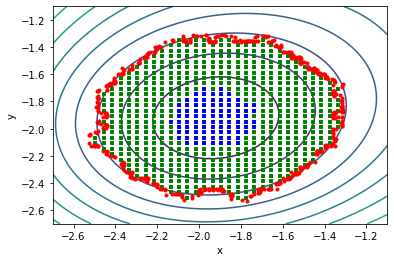

In [11]:
## Add code here to plot first_crosses, basinA_set, lambda_0_set
## Basin A in blue, lambda_0 in green, first crossing configs in red.
import cffs_util as cffs
point_size = 3
cffs.plot_set_cross(x_range,y_range,contours,basin_A_set,lambda_0_set,first_crosses,grid,point_size,pes_type)

In [12]:
## Prep for iterative FFS over each interface

# Randomly select first crossings to launch trajectories from at the first interface
configs = np.asarray(random.choices(first_crosses,k=interface_trajs))

# Make the active set the lambda_0_set
active_set = lambda_0_set

cross_probs = []
success_probs = []


Starting interface 0...
Total first crossings: 3773


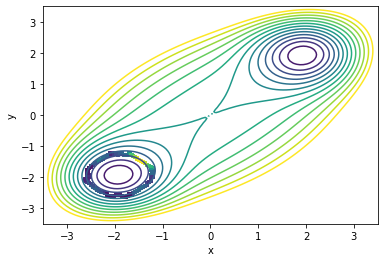

Total first crossings: 2140
Total first crossings: 1269
Total first crossings: 885
Total first crossings: 634
Total first crossings: 546
Total first crossings: 515
Total first crossings: 507
0 to 1 crossing probability:   0.0982
0 to B crossing probability:   0.0000


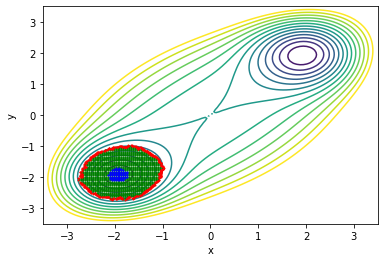

Starting interface 1...
Total first crossings: 3627


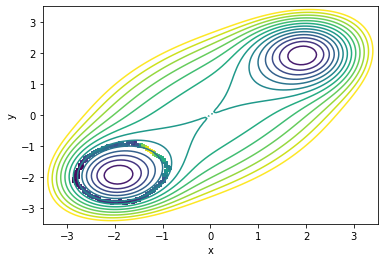

Total first crossings: 1902
Total first crossings: 1174
Total first crossings: 900
Total first crossings: 727
Total first crossings: 633
Total first crossings: 587
Total first crossings: 568
Total first crossings: 546
Total first crossings: 528
Total first crossings: 516


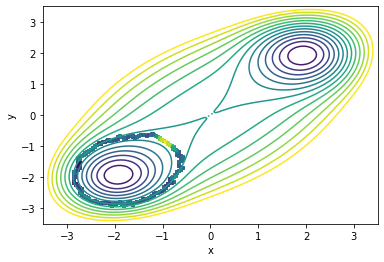

Total first crossings: 508
Total first crossings: 504
1 to 2 crossing probability:   0.0998
1 to B crossing probability:   0.0000


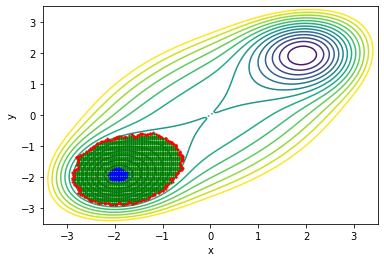

Starting interface 2...
Total first crossings: 3575


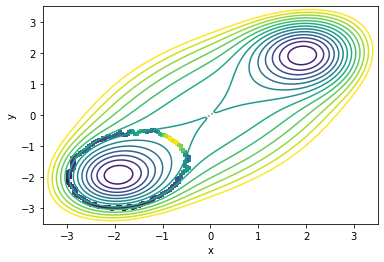

Total first crossings: 2136
Total first crossings: 1491
Total first crossings: 1196
Total first crossings: 1032
Total first crossings: 953
Total first crossings: 888
Total first crossings: 831
Total first crossings: 789
Total first crossings: 767
Total first crossings: 745


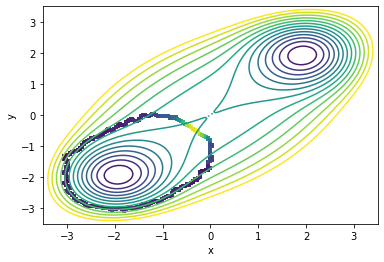

Total first crossings: 720
Total first crossings: 691
Total first crossings: 673
Total first crossings: 665
Total first crossings: 644
Total first crossings: 631
Total first crossings: 612
Total first crossings: 606
Total first crossings: 597
Total first crossings: 590


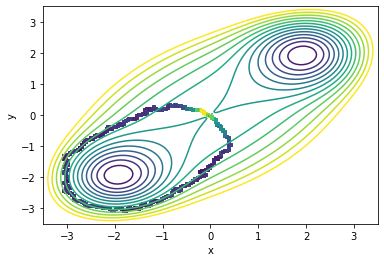

Total first crossings: 584
Total first crossings: 578
Total first crossings: 575
Total first crossings: 575
Total first crossings: 572
Total first crossings: 564
Total first crossings: 562
Total first crossings: 557
Total first crossings: 555
Total first crossings: 554


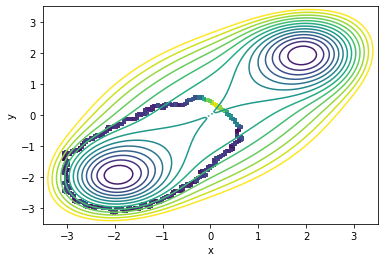

Total first crossings: 541
Total first crossings: 540
Total first crossings: 537
Total first crossings: 535
Total first crossings: 534
Total first crossings: 534
Total first crossings: 534
Total first crossings: 530
Total first crossings: 525
Total first crossings: 522


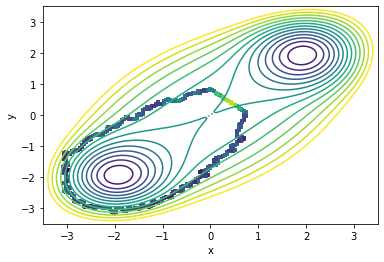

Total first crossings: 520
Total first crossings: 519
Total first crossings: 516
Total first crossings: 515
Total first crossings: 515
Total first crossings: 513
Total first crossings: 513
Total first crossings: 512
Total first crossings: 512
Total first crossings: 512


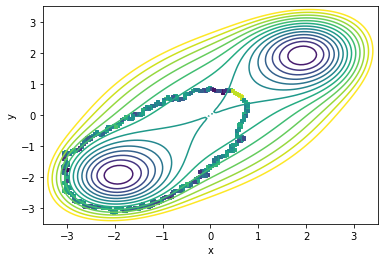

Total first crossings: 512
Total first crossings: 510
Total first crossings: 510
Total first crossings: 509
Total first crossings: 509
Total first crossings: 509
Total first crossings: 509
Total first crossings: 509
2 to 3 crossing probability:   0.1018
2 to B crossing probability:   0.0000


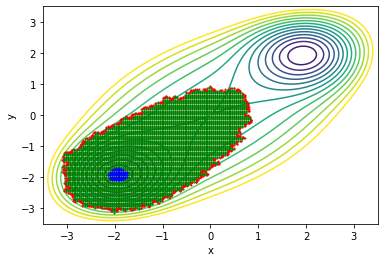

Starting interface 3...
Total first crossings: 3732


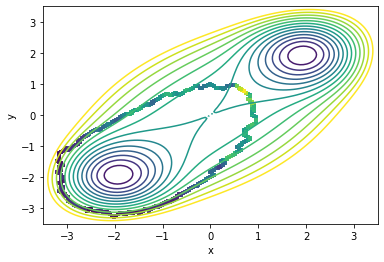

Total first crossings: 2634
Total first crossings: 2230
Total first crossings: 1975
Total first crossings: 1850
Total first crossings: 1745
Total first crossings: 1673
Total first crossings: 1607
Total first crossings: 1559
Total first crossings: 1536
Total first crossings: 1515


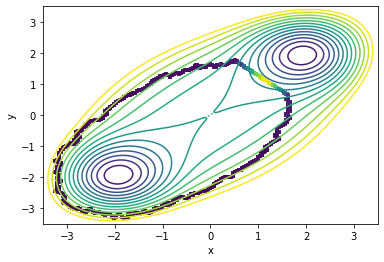

Total first crossings: 1492
Total first crossings: 1470
Total first crossings: 1461
Total first crossings: 1455
Total first crossings: 1454
Total first crossings: 1451
Total first crossings: 1447
Total first crossings: 1447
Total first crossings: 1447
Total first crossings: 1447


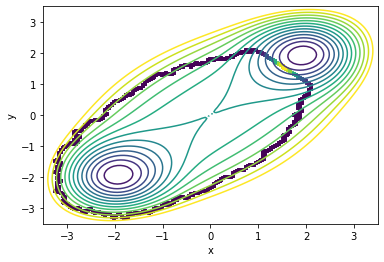

Total first crossings: 1447
Total first crossings: 1447
Total first crossings: 1447
Total first crossings: 1441
Total first crossings: 1253
Total first crossings: 1064
Total first crossings: 855
Total first crossings: 731
Total first crossings: 625
Total first crossings: 598


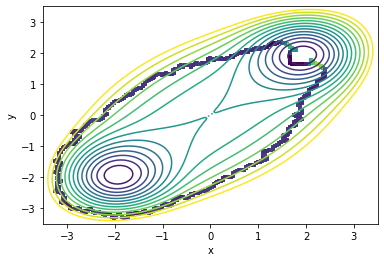

Total first crossings: 573
Total first crossings: 550
Total first crossings: 537
Total first crossings: 522
Total first crossings: 512
Total first crossings: 505
3 to 4 crossing probability:   0.0992
3 to B crossing probability:   0.1874


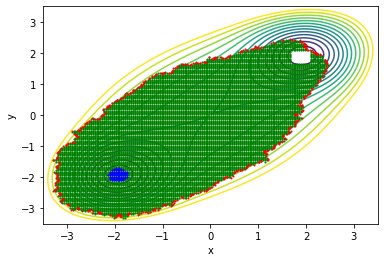

Starting interface 4...
Total first crossings: 3551
4 to 5 crossing probability:   0.0000
4 to B crossing probability:   0.4336


In [14]:
for i in range(n_interfaces):
    # First run simulations
    inttrajs = []
    print("Starting interface %d..." % i)
    first_crosses = []
    n_cross = 0
    for config in configs:
        bin_cv1 = int((config[0]-grid.min_cv1)/grid.size_cv1)
        bin_cv2 = int((config[1]-grid.min_cv2)/grid.size_cv2)
        loc = (bin_cv1,bin_cv2)
        step = 0
        traj = []
        traj.append(config)
        # Run simulation until A or B is reached
        while loc not in basin_A_set and loc not in basin_B_set:
            traj.append(ld.vv_step(traj[step],dt,beta,gamma,pes_type))
            step += 1
            bin_cv1 = int((traj[step][0]-grid.min_cv1)/grid.size_cv1)
            bin_cv2 = int((traj[step][1]-grid.min_cv2)/grid.size_cv2)
            loc = (bin_cv1,bin_cv2)

        inttrajs.append(traj)

    # Then we analyze them with the same approach 
    # as above to place interface i+1

    # 1. Extend old set
    #    This function adds a single 'layer' of sites
    #    We do this first to ensure that interfaces do not overlap
    newset = cffs.extend_set_everywhere(active_set,basin_B_set,grid)
    # 2. Use the same trick to ensure the set has no 'holes'
    cls = cffs.idnosetcls(newset,grid) 
    noset = max(cls, key=len)
    active_set = set()
    for bin_cv1 in range(grid.nbins_cv1):
        for bin_cv2 in range(grid.nbins_cv2):
            if (bin_cv1,bin_cv2) not in noset:
                active_set.add((bin_cv1,bin_cv2))
    
    # 3. Find edges of set. Edges are any sites 
    #    with < 4 neighbors in the same set
    edges = cffs.loc_edges(active_set)
    # 4. Calculate number of first crossings
    #    exiting through each edge site.
    first_crosses,n_cross,n_basin,n_success,avg_edgecount = cffs.calc_exit(inttrajs,grid,basin_A_set,basin_B_set,active_set,edges)
    if (n_cross + n_basin + n_success) != interface_trajs:
        print("n_cross = %d" % n_cross)
        print("n_basin = %d" % n_basin)
        print("n_success = %d" % n_success)
        print("interface_trajs = %d" % interface_trajs)
        sys.exit("Number of cross, success, and basin did not sum to interface_trajs")

    old_edges = set()
    # Repeat the above steps until 
    # n_cross < cross_threshold 
    # or edges is unchanging
    itr = 0
    while n_cross > cross_threshold and edges != old_edges:
        print("Total first crossings: %d" % n_cross)
        # We don't just extend the set in all directions. 
        # We need to know the desired crossing density (from current number of 
        # edges and the total number of desired crossings)
        dens_threshold = cross_threshold/len(edges)
        repeatFlag = True
        while repeatFlag == True:
            adddens = 0.0
            for x in avg_edgecount:
                if avg_edgecount[x] < dens_threshold:
                    adddens+= dens_threshold-avg_edgecount[x]
            dens_threshold_new = (cross_threshold + adddens)/len(edges)
            if abs(dens_threshold_new-dens_threshold)/dens_threshold < 0.05:
                repeatFlag = False
            else:
                dens_threshold=dens_threshold_new
    
        # 5. Add to set for sites with greater than required crossing density
        newset = cffs.extend_set_selective(active_set,edges,avg_edgecount,dens_threshold,basin_B_set,grid)
        # Apply the same 'trick' to remove holes
        cls = cffs.idnosetcls(newset,grid) 
        noset = max(cls, key=len)
        active_set = set()
        for bin_cv1 in range(grid.nbins_cv1):
            for bin_cv2 in range(grid.nbins_cv2):
                if (bin_cv1,bin_cv2) not in noset:
                    active_set.add((bin_cv1,bin_cv2))
        # 3. Find edges of set. Edges are any sites 
        #    with < 4 neighbors in the same set
        old_edges = edges
        edges = cffs.loc_edges(active_set)
        # Check if active set has surrounded B (if yes we are done)
        completeFlag = True
        for siteB in basin_B_set:
            if siteB not in active_set:
                completeFlag = False
                break
       
        if completeFlag == False:
            # 4. Calculate number of first crossings
            #    exiting through each edge site.
            first_crosses,n_cross,n_basin,n_success,avg_edgecount = cffs.calc_exit(inttrajs,grid,basin_A_set,basin_B_set,active_set,edges)
            if (n_cross + n_basin + n_success) != interface_trajs:
                print("n_cross = %d" % n_cross)
                print("n_basin = %d" % n_basin)
                print("n_success = %d" % n_success)
                print("interface_trajs = %d" % interface_trajs)
                sys.exit("Number of cross, success, and basin did not sum to interface_trajs")
            # Plot set growth (ev. five iterations)
            x_range = [-3.5,3.5]
            y_range = [-3.5,3.5]
            point_size = 10
            if itr % 10 == 0:
                cffs.plot_edges(x_range,y_range,contours,edges,avg_edgecount,grid,point_size,pes_type)
            itr += 1
        # Complete flag is then True
        else:
            n_basin,n_success = cffs.calc_exit_final(inttrajs,grid,basin_A_set,basin_B_set)
            n_cross = 0
            if (n_basin + n_success) != interface_trajs:
                print("n_basin = %d" % n_basin)
                print("n_success = %d" % n_success)
                print("interface_trajs = %d" % interface_trajs)
                sys.exit("Number of cross, success, and basin did not sum to interface_trajs")
            break
    
    # Now we have the final lambda_{i+1}_set and interface crossings...
    cross_prob = float(n_cross)/float(interface_trajs)
    success_prob = float(n_success)/float(interface_trajs)
    cross_probs.append(cross_prob)
    success_probs.append(success_prob)
    print("%d to %d crossing probability: %8.4f" % (i,i+1,cross_prob))
    print("%d to B crossing probability: %8.4f" % (i,success_prob))

    if completeFlag == True:
        break
    
    # Randomly select first crossings to launch trajectories from at the first interface
    configs = np.asarray(random.choices(first_crosses,k=interface_trajs))
    
    # Plot final interface set with first crosses
    ## Add code here to plot first_crosses, basinA_set, lambda_0_set
    ## Basin A in blue, active_set in green, first crossing configs in red.
    point_size = 1
    cffs.plot_set_cross(x_range,y_range,contours,basin_A_set,active_set,first_crosses,grid,point_size,pes_type)

In [15]:
# And calculate the rate
prob_0_B = 0.0
prob_0_i = 1.0
for i in range(len(cross_probs)-1):
    prob_0_i *= cross_probs[i]
    prob_0_B += prob_0_i*success_probs[i+1]

rate = flux*prob_0_B

print("The flux from A to 0 was %8.3f" % flux)
print("The probability of reaching B from 0 was %8.3e" % prob_0_B)
print("The estimated rate constant is %8.3e" % rate)

The flux from A to 0 was    0.099
The probability of reaching B from 0 was 2.299e-04
The estimated rate constant is 2.285e-05
